In [31]:
# import numpy as np
# import matplotlib.pyplot as plt
# import keras


# # Configuration parameters
# AVOID_OVERFITTING = False  # Set to True to enable L2 regularization
# N_EPOCHS = 10000
# HIDDEN_UNITS = 64
# LEARNING_RATE = 0.01
# L2_REGULARIZATION = 0.01  # Used only if AVOID_OVERFITTING is True

# # Generate random data
# np.random.seed(0)  # for reproducibility
# X = np.load("/tmp/res_x_scaled.npy")
# y = np.load("/tmp/res_y_scaled.npy")


# # Create the model
# model = keras.Sequential([keras.Input((1,))])
# if AVOID_OVERFITTING:
#     model.add(
#         keras.layers.Dense(
#             HIDDEN_UNITS,
#             activation="relu",
#             kernel_regularizer=keras.regularizers.l2(L2_REGULARIZATION),
#         )
#     )
# else:
#     model.add(keras.layers.Dense(HIDDEN_UNITS, activation="relu"))
# model.add(keras.layers.Dense(1))

# # Compile the model
# optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# model.compile(optimizer=optimizer, loss="mse")

# # Train the model
# history = model.fit(
#     X,
#     y,
#     epochs=N_EPOCHS,
#     batch_size=100,
#     verbose="1",
#     callbacks=[keras.callbacks.EarlyStopping("loss", patience=200, min_delta=0.001)],
# )

# # Plot the results
# X_test = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
# y_pred = model.predict(X_test)

# plt.scatter(X, y, label="Training Data")
# plt.plot(X_test, y_pred, color="red", label="Learned Function")
# plt.title(f"{'Overfitted ' if not AVOID_OVERFITTING else ''}MLP Regression")
# plt.xlabel("X")
# plt.ylabel("y")
# plt.legend()

# # Plot the training loss
# plt.figure()
# plt.semilogy(history.history["loss"])
# plt.title("Training Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")


# plt.show()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 4.4 K  | train
----------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.017     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 106.08it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 61.89it/s, v_num=16] 


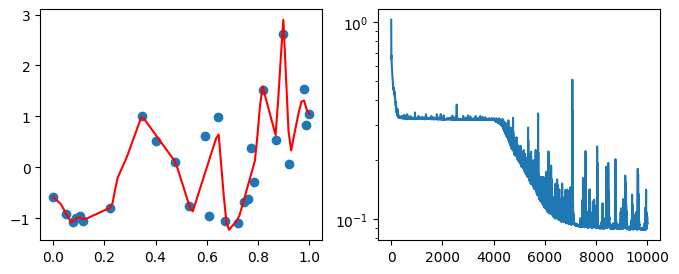

Min loss: 0.08789082616567612


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import lightning as pl

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader, TensorDataset


# Configuration parameters
AVOID_OVERFITTING = False  # Set to True to enable L2 regularization
N_EPOCHS = 10000
HIDDEN_UNITS = 64
# LEARNING_RATE = 0.1  # 0.4886
LEARNING_RATE = 0.01
L2_REGULARIZATION = 0.01  # Used only if AVOID_OVERFITTING is True

# Generate random data
np.random.seed(0)  # for reproducibility
X = np.load("/tmp/res_x_scaled.npy")
y = np.load("/tmp/res_y_scaled.npy")

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


class RegressionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, HIDDEN_UNITS),
            nn.ReLU(),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.ReLU(),
            nn.Linear(HIDDEN_UNITS, 1),
        )
        self.l2_reg = L2_REGULARIZATION if AVOID_OVERFITTING else 0
        self.loss_train = []

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)

        # if self.l2_reg > 0:
        #     l2_norm = sum(p.pow(2.0).sum() for p in self.parameters())
        #     loss = loss + self.l2_reg * l2_norm

        self.log("train_loss", loss)
        # if batch_idx == 0:
        self.loss_train.append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        return optimizer


# Create the model
model = RegressionModel()

# Create the dataloader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=100)

# Create the trainer
trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    # callbacks=[EarlyStopping("train_loss", patience=200, min_delta=0.001)],
)

# Train the model
trainer.fit(model, train_loader)


# Plot the results
X_test = torch.linspace(X.min(), X.max(), 100).reshape(-1, 1)
with torch.no_grad():
    y_pred = model(X_test)

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
axs[0].scatter(X, y, label="Training Data")
axs[0].plot(X_test, y_pred, color="red", label="Learned Function")

train_loss_history = np.array(model.loss_train)
axs[1].semilogy(train_loss_history)
plt.show()
print(f"Min loss: {train_loss_history.min()}")

!say "Done"

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 4.4 K  | train
----------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.017     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 99999: 100%|██████████| 1/1 [00:00<00:00, 110.35it/s, v_num=18]

`Trainer.fit` stopped: `max_epochs=100000` reached.


Epoch 99999: 100%|██████████| 1/1 [00:00<00:00, 60.59it/s, v_num=18] 


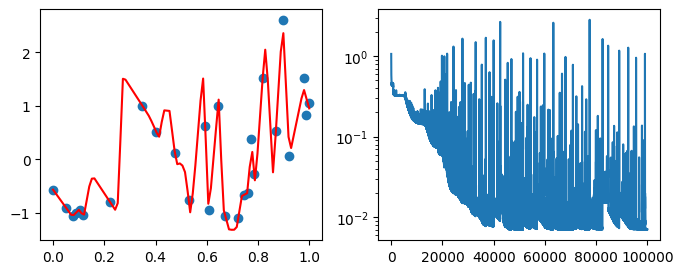

Min loss: 0.0070345900021493435


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import lightning as pl

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader, TensorDataset


# Configuration parameters
AVOID_OVERFITTING = False  # Set to True to enable L2 regularization
N_EPOCHS = 100000
HIDDEN_UNITS = 64
# LEARNING_RATE = 0.1  # 0.4886
LEARNING_RATE = 0.01
L2_REGULARIZATION = 0.01  # Used only if AVOID_OVERFITTING is True

# Generate random data
np.random.seed(0)  # for reproducibility
X = np.load("/tmp/res_x_scaled.npy")
y = np.load("/tmp/res_y_scaled.npy")

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


class RegressionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, HIDDEN_UNITS),
            nn.ReLU(),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.ReLU(),
            nn.Linear(HIDDEN_UNITS, 1),
        )
        self.l2_reg = L2_REGULARIZATION if AVOID_OVERFITTING else 0
        self.loss_train = []

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)

        # if self.l2_reg > 0:
        #     l2_norm = sum(p.pow(2.0).sum() for p in self.parameters())
        #     loss = loss + self.l2_reg * l2_norm

        self.log("train_loss", loss)
        # if batch_idx == 0:
        self.loss_train.append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        return optimizer


# Create the model
model = RegressionModel()

# Create the dataloader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=100)

# Create the trainer
trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    # callbacks=[EarlyStopping("train_loss", patience=200, min_delta=0.001)],
)

# Train the model
trainer.fit(model, train_loader)


# Plot the results
X_test = torch.linspace(X.min(), X.max(), 100).reshape(-1, 1)
with torch.no_grad():
    y_pred = model(X_test)

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
axs[0].scatter(X, y, label="Training Data")
axs[0].plot(X_test, y_pred, color="red", label="Learned Function")

train_loss_history = np.array(model.loss_train)
axs[1].semilogy(train_loss_history)
plt.show()
print(f"Min loss: {train_loss_history.min()}")

!say "Done"
# shampoo

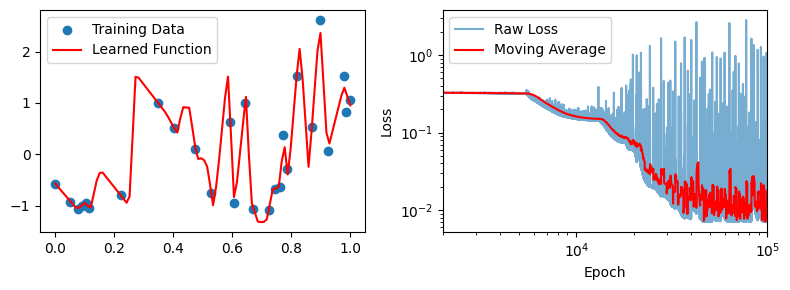

Min loss: 0.0070345900021493435


In [56]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ... (your existing code to define and train the model) ...

# Plot the results
X_test = torch.linspace(X.min(), X.max(), 100).reshape(-1, 1)
with torch.no_grad():
    y_pred = model(X_test)

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
axs[0].scatter(X, y, label="Training Data")
axs[0].plot(X_test, y_pred, color="red", label="Learned Function")
axs[0].legend()


train_loss_history = np.array(model.loss_train)

# Calculate moving average
window_size = 1000  # Adjust this value as needed
weights = np.repeat(1.0, window_size) / window_size
moving_average = np.convolve(train_loss_history, weights, "valid")


axs[1].loglog(
    train_loss_history, label="Raw Loss", alpha=0.6
)  # Plot raw loss with reduced opacity
axs[1].loglog(
    np.arange(window_size - 1, len(train_loss_history)),
    moving_average,
    label="Moving Average",
    color="red",
)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].set_xlim(2000, 10**5)
axs[1].legend()


plt.tight_layout()  # Adjust subplot params for a tight layout
plt.show()
print(f"Min loss: {train_loss_history.min()}")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 4.4 K  | train
----------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.017     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 76.55it/s, v_num=31] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 51.55it/s, v_num=31]


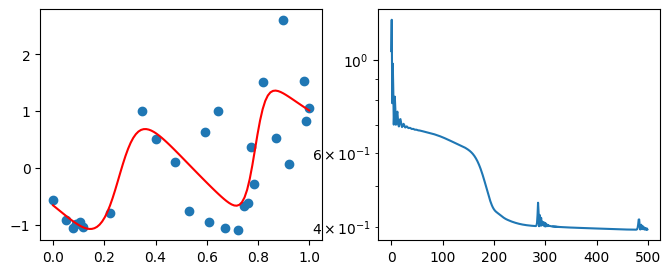

Min loss: 0.39385688304901123


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import lightning as pl

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader, TensorDataset


# Configuration parameters
AVOID_OVERFITTING = True  # Set to True to enable L2 regularization
N_EPOCHS = 500
HIDDEN_UNITS = 64
# LEARNING_RATE = 0.1  # 0.4886
LEARNING_RATE = 0.01
L2_REGULARIZATION = 0.0005  # Used only if AVOID_OVERFITTING is True

# Generate random data
np.random.seed(0)  # for reproducibility
X = np.load("/tmp/res_x_scaled.npy")
y = np.load("/tmp/res_y_scaled.npy")

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


class RegressionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, HIDDEN_UNITS),
            nn.Tanh(),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.Tanh(),
            nn.Linear(HIDDEN_UNITS, 1),
        )
        self.l2_reg = L2_REGULARIZATION if AVOID_OVERFITTING else 0
        self.loss_train = []

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)

        if self.l2_reg > 0:
            l2_norm = sum(p.pow(2.0).sum() for p in self.parameters())
            loss = loss + self.l2_reg * l2_norm

        self.log("train_loss", loss)
        # if batch_idx == 0:
        self.loss_train.append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        return optimizer


# Create the model
model = RegressionModel()

# Create the dataloader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=100)

# Create the trainer
trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    # callbacks=[EarlyStopping("train_loss", patience=200, min_delta=0.001)],
)

# Train the model
trainer.fit(model, train_loader)


# Plot the results
X_test = torch.linspace(X.min(), X.max(), 100).reshape(-1, 1)
with torch.no_grad():
    y_pred = model(X_test)

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
axs[0].scatter(X, y, label="Training Data")
axs[0].plot(X_test, y_pred, color="red", label="Learned Function")

train_loss_history = np.array(model.loss_train)
axs[1].semilogy(train_loss_history)
plt.show()
print(f"Min loss: {train_loss_history.min()}")

!say "Done"

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 193    | train
----------------------------------------------
193       Trainable params
0         Non-trainable params
193       Total params
0.001     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 105.12it/s, v_num=42]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 70.77it/s, v_num=42] 


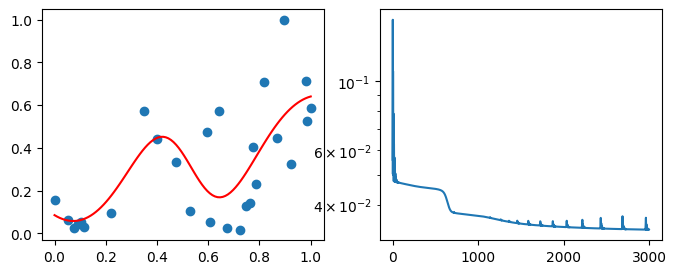

Min loss: 0.03324362263083458


In [83]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import lightning as pl

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader, TensorDataset


# Configuration parameters
AVOID_OVERFITTING = True  # Set to True to enable L2 regularization
N_EPOCHS = 3000
HIDDEN_UNITS = 64
# LEARNING_RATE = 0.1  # 0.4886
LEARNING_RATE = 0.01
L2_REGULARIZATION = 0.00001  # Used only if AVOID_OVERFITTING is True

# Generate random data
np.random.seed(0)  # for reproducibility
X = np.load("/tmp/res_x_scaled.npy")
y = np.load("/tmp/res_y_scaled.npy")

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


class RegressionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, HIDDEN_UNITS),
            # nn.Tanh(),
            # nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.Tanh(),
            nn.Linear(HIDDEN_UNITS, 1),
        )
        self.l2_reg = L2_REGULARIZATION if AVOID_OVERFITTING else 0
        self.loss_train = []

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)

        if self.l2_reg > 0:
            l2_norm = sum(p.pow(2.0).sum() for p in self.parameters())
            loss = loss + self.l2_reg * l2_norm

        self.log("train_loss", loss)
        # if batch_idx == 0:
        self.loss_train.append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        return optimizer


# Create the model
model = RegressionModel()

# Create the dataloader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=100)

# Create the trainer
trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    # callbacks=[EarlyStopping("train_loss", patience=200, min_delta=0.001)],
)

# Train the model
trainer.fit(model, train_loader)


# Plot the results
X_test = torch.linspace(X.min(), X.max(), 100).reshape(-1, 1)
with torch.no_grad():
    y_pred = model(X_test)

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
axs[0].scatter(X, y, label="Training Data")
axs[0].plot(X_test, y_pred, color="red", label="Learned Function")

train_loss_history = np.array(model.loss_train)
axs[1].semilogy(train_loss_history)
plt.show()
print(f"Min loss: {train_loss_history.min()}")

In [1]:
import os

# This guide can only be run with the jax backend.
os.environ["KERAS_BACKEND"] = "tensorflow"

tensorflow
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


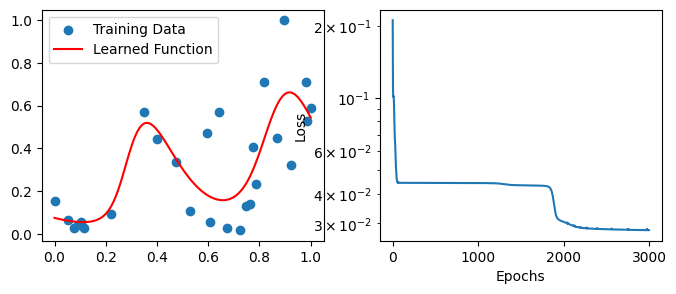

Min loss: 0.028118126094341278


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import keras

print(keras.backend.backend())

# Configuration parameters
# AVOID_OVERFITTING = True  # Set to True to enable L2 regularization
# N_EPOCHS = 5000
# HIDDEN_UNITS = 64
# LEARNING_RATE = 0.01
# L2_REGULARIZATION = 0.000001  # Used only if AVOID_OVERFITTING is True
AVOID_OVERFITTING = True  # Set to True to enable L2 regularization
N_EPOCHS = 3000
HIDDEN_UNITS = 64
# LEARNING_RATE = 0.1  # 0.4886
# LEARNING_RATE = 0.05  # works
LEARNING_RATE = 0.01  #
# L2_REGULARIZATION = 0.00001  # works
# L2_REGULARIZATION = 0.0001  # works also
L2_REGULARIZATION = 0.000001  #

# Load data (assuming same data loading as PyTorch version)
np.random.seed(0)
X = np.load("/tmp/res_x_scaled.npy").reshape(-1, 1)
y = np.load("/tmp/res_y_scaled.npy").reshape(-1, 1)

X = X.astype(np.float32)  # Ensure correct dtype
y = y.astype(np.float32)

# Define the Keras model
model = keras.Sequential(
    [
        keras.Input((1,)),
        keras.layers.Dense(
            HIDDEN_UNITS,
            activation="tanh",
            kernel_regularizer=keras.regularizers.l2(L2_REGULARIZATION)
            if AVOID_OVERFITTING
            else None,
        ),
        keras.layers.Dense(1),  # Output layer, no activation for regression
        # keras.layers.Lambda(lambda x: keras.ops.abs(x)),
        keras.layers.Activation("softplus"),
    ]
)


# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="mse")

# Train the model
history = model.fit(
    keras.ops.convert_to_tensor(X),
    keras.ops.convert_to_tensor(y),
    epochs=N_EPOCHS,
    batch_size=100,
    verbose=0,
)

# Plot the results
X_test = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = model.predict(X_test)


fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
axs[0].scatter(X, y, label="Training Data")
axs[0].plot(X_test, y_pred, color="red", label="Learned Function")
axs[0].legend()


axs[1].semilogy(history.history["loss"])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
plt.show()

print(f"Min loss: {min(history.history['loss'])}")

!say "Done"